# Assessing birth-death-mutation model MLE convergence

In [1]:
import itertools
import jax.numpy as np
import matplotlib.pyplot as plt
import pickle
from gcdyn import bdms
from gcdyn.model import Model
from jax import jit, grad
from tqdm.auto import tqdm
from collections import namedtuple

def plot_curve(*θ_values, range = (-10, 10), **named_θ_values):
    x_array = np.linspace(*range)
    λ = lambda θ: Model.λ(None, x_array, θ)

    plt.figure()

    for θ in θ_values:
        plt.plot(x_array, λ(θ), color = "black", alpha = 0.5)

    for name, θ in named_θ_values.items():
        plt.plot(x_array, λ(θ), label = name)
    
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\lambda_\theta(x)$")
    plt.xlim(*range)
    
    if named_θ_values:
        plt.legend()

    plt.show()


def evolve_trees(num_trees, **evolve_kwargs):
    trees = [bdms.TreeNode() for _ in range(num_trees)]

    seed = evolve_kwargs.pop("seed", None)

    for tree in trees:
        tree.evolve(seed = seed, **evolve_kwargs)

        if seed is not None:
            seed = seed + 1

    return trees


def prune_trees(trees, ρ):
    copied_trees = [tree.copy() for tree in trees]

    for tree in copied_trees:
        # if statement is for not having an error if you call it twice accidentally
        if not tree._sampled:
            tree.sample_survivors(p = ρ)
            tree.prune()

    return copied_trees

## Demo usage of gcdyn module

### Example 1

In [2]:
θ = [2, 1, 0, 0]
num_trees = 2

Average of 208.5 nodes per tree
Solution in 15 iterations: [ 1.8693697   3.5055227  -0.08554897  0.        ]


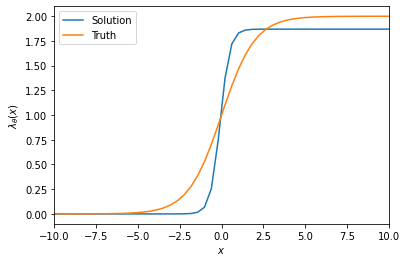

In [3]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)
print("Average of", sum(len(list(tree.traverse())) for tree in trees) / num_trees, "nodes per tree")

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit()
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ)

### Example 2

In [4]:
θ = [-2, 1, 0, 2]
num_trees = 2

Average of 710.0 nodes per tree
Solution in 34 iterations: [-13.65231      0.41709074   5.4624643    2.088384  ]


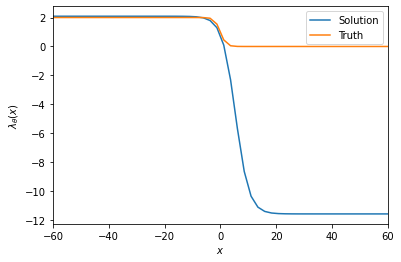

In [5]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)
print("Average of", sum(len(list(tree.traverse())) for tree in trees) / num_trees, "nodes per tree")

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [-np.inf, 0.0, -np.inf, 0.0])
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ, range = (-60, 60))

Try changing the mutation shift to be positive (which is toward lower birth rates in this model)

Average of 536.5 nodes per tree
Solution in 15 iterations: [-4.326403   1.8958575 -4.5996256  1.6254574]


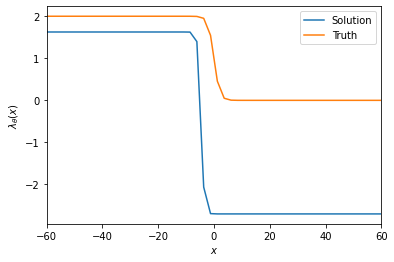

In [6]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(1, 1),
    min_survivors = 20,
    seed          = 2
)
print("Average of", sum(len(list(tree.traverse())) for tree in trees) / num_trees, "nodes per tree")

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)


mle = model.fit(init_value = θ, lower_bounds = [-np.inf, 0, -np.inf, 0])
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ, range = (-60, 60))

Notice how the JIT compile time drops as the sizes of the trees drops...

Average of 259.0 nodes per tree
Solution in 13 iterations: [-6.751621    0.5452717  -1.4965268   0.81424296]


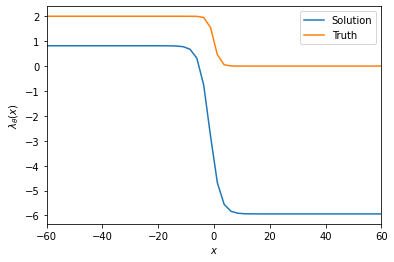

In [7]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(1, 1),
    min_survivors = 20,
    seed          = 20,
    retry         = 10000
)
print("Average of", sum(len(list(tree.traverse())) for tree in trees) / num_trees, "nodes per tree")

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)


mle = model.fit(init_value = θ, lower_bounds = [-np.inf, 0, -np.inf, 0])
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ, range = (-60, 60))

## Code to try different initial values for MLE runs

Note that this still assumes a single model with a fixed $θ$; we just try to run the algorithm from different starting points.

In [8]:
def try_init_values(model, true_θ, *search_ranges, print_skipped_values = False):
    """
    Runs MLE algorithm for `model` starting from points in the specified range of initial values,
    and plots the resulting log likelihoods against the distance of the initial value from the true parameter value.
    """

    true_θ = np.array(true_θ)

    search_space = itertools.product(*search_ranges)
    search_space = [np.array(t, dtype = float) for t in search_space]

    magnitudes = []
    log_liks = []
    skipped_values = []

    Result = namedtuple("Result", ("θ_init", "θ_result", "magnitude", "log_lik"))
    Result.__repr__ = lambda self: f"θ_init: {self.θ_init}, magnitude: {self.magnitude}, log lik: {self.log_lik}, θ_result: {self.θ_result}"
    results = []

    for θ_init in tqdm(search_space, desc = "Init value #"):
        result = model.fit(init_value = θ_init)
        log_lik = result.state.fun_val

        if np.isnan(log_lik):
            skipped_values.append(θ_init)

        else:
            results.append(Result(
                θ_init    = θ_init,
                θ_result  = result.params,
                magnitude = np.sqrt(np.power(true_θ - θ_init, 2).sum()),
                log_lik   = log_lik
            ))

    magnitudes = np.array([result.magnitude for result in results])
    log_liks = np.array([result.log_lik for result in results])

    plt.scatter(magnitudes, log_liks)
    plt.xlabel(r"$||\theta - \theta\_init||$")
    plt.ylabel("log likelihood of result")
    plt.show()

    if skipped_values:
        print(f"Note: {len(skipped_values)}/{len(search_space)} initial values were skipped.")

        if print_skipped_values:
            for val in skipped_values:
                print(val)
        
        else:
            print("Pass argument `print_skipped_values = True` to see them.")

    return results

Init value #:   0%|          | 0/1250 [00:00<?, ?it/s]

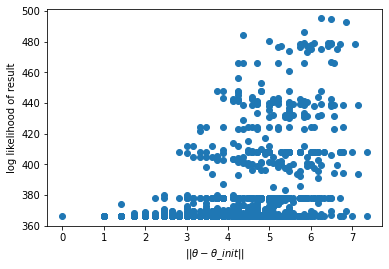

Note: 50/1250 initial values were skipped.
Pass argument `print_skipped_values = True` to see them.


In [9]:
θ = [2, 1, 0, 0]
num_trees = 1

trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

results = try_init_values(model, θ, range(0, 5), range(0, 5), range(-5, 5), range(0, 5))

## MLE on BEAST trees

Interestingly, even though we have more trees, the JIT compile time is quite quick...

Average of 302.0 nodes per tree, over 21 trees
Solution in 6 iterations: [2.0692263  1.2352401  2.377035   0.01314545]


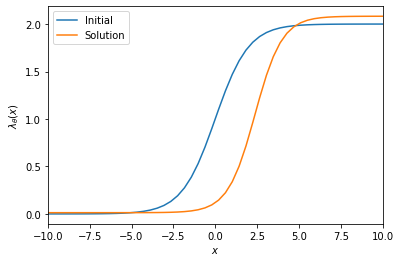

In [10]:
with open("tenseqs_subset-ete3_trees.pickle", "rb") as trees_file:
    beast_trees = pickle.load(trees_file)

some_trees = list(beast_trees.values())[80:]
print("Average of", sum(len(list(tree.traverse())) for tree in trees) / num_trees, "nodes per tree, over", len(some_trees), "trees")

model = Model(some_trees, μ = 1, γ = 1, ρ = 0.5)

θ_init = [2, 1, 0, 0]
mle = model.fit(init_value = θ_init)
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Initial = θ_init, Solution = mle.params)

## What if we prune the trees?

### Example 1

In [11]:
θ = [2, 1, 0, 0]
num_trees = 1

Pruning is a random procedure, so we can run independent/parallel prunes and observe the different results we obtain, like a confidence band of sorts

Truth: [2, 1, 0, 0]
Solution in 13 iterations: [ 1.9068173   2.752452   -0.04683809  0.        ]
Solution after pruning: [ 0.70865726 98.43093     0.87359244  0.14161572]
Solution after pruning: [1.0417943  0.16651982 2.196611   0.23320635]
Solution after pruning: [  0.6181245  115.86111      0.86989766   0.14162698]
Solution after pruning: [1.3578341  0.69679856 1.1826925  0.00540955]
Solution after pruning: [  0.46037075 100.72286      1.4263471    0.44827938]
Solution after pruning: [1.2165738 0.4797513 0.9677429 0.       ]
Solution after pruning: [1.2319947 0.4442691 1.3955264 0.       ]
Solution after pruning: [1.0963545  0.04226618 1.3991429  0.2603584 ]
Solution after pruning: [0.91275585 0.37196347 3.003742   0.21567604]
Solution after pruning: [  0.5538328  104.47836      0.86057717   0.26210558]


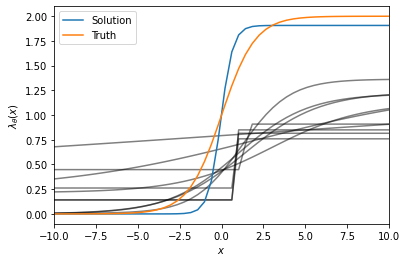

In [12]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ)
print(f"Truth: {θ}")
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")

pruned_mles = []

for _ in range(10):
    # Because of JIT, you need to build a new model with the modified trees
    model = Model(prune_trees(trees, ρ = 0.5), μ = 1, γ = 1, ρ = 0.5)

    pruned_mle = model.fit(init_value = θ)
    print(f"Solution after pruning: {pruned_mle.params}")

    pruned_mles.append(pruned_mle)

plot_curve(*[mle.params for mle in pruned_mles], Solution = mle.params, Truth = θ)

### Example 2

In [13]:
θ = [2, -1, 0, 0]
num_trees = 1

Truth: [2, -1, 0, 0]
Solution: [2.1474936  0.         0.         0.29498714]
Solution after pruning: [ 1.2653650e+00  1.5415143e-02 -3.3270738e-01  7.1920931e-07]
Solution after pruning: [ 1.4136235   0.33678603 -0.60366625  0.        ]
Solution after pruning: [ 0.80481386  0.07666222 -0.12677196  0.1913727 ]
Solution after pruning: [  0.6358876  -13.524179     0.69894046   0.        ]
Solution after pruning: [ 0.842626   3.0233526 -1.6648749  0.       ]
Solution after pruning: [ 0.4714035 40.479218  -1.64078    0.1620362]
Solution after pruning: [ 0.3600711  40.035362   -1.3771054   0.45711014]
Solution after pruning: [ 0.88189703 -0.99674946  0.04665576  0.        ]
Solution after pruning: [ 0.9595332  5.846918  -1.5453144  0.       ]
Solution after pruning: [ 1.2099339  0.6172392 -1.4679173  0.       ]


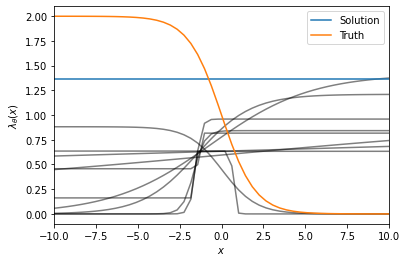

In [14]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(1, 1),
    min_survivors = 20,
    seed          = 2
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [-np.inf, 0, -np.inf, 0])
print(f"Truth: {θ}")
print(f"Solution: {mle.params}")

pruned_mles = []

for _ in range(10):
    # Because of JIT, you need to build a new model with the modified trees
    model = Model(prune_trees(trees, ρ = 0.5), μ = 1, γ = 1, ρ = 0.5)

    pruned_mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
    print(f"Solution after pruning: {pruned_mle.params}")

    pruned_mles.append(pruned_mle)

plot_curve(*[mle.params for mle in pruned_mles], Solution = mle.params, Truth = θ)